# Albumentation Classification

### Firstly, we need to  preprocess our data and use albumentation as augmentor. In order to do that I created a class named AlzheimerDataset. That class is preprocessing the data and return image-labels...

In [3]:
import torch
import torch.nn as nn

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import io
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from tqdm import tqdm
import warnings
import pandas as pd

import albumentations as A
from PIL import Image
import cv2
from albumentations.pytorch import ToTensorV2
warnings.simplefilter('ignore')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

class AlzheimerDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "Mild_Demented":
            label = 0
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "Moderate_Demented":
            label=1
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "Non_Demented":
            label=2
        else:
            label = 3
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label


cuda:0
Tesla P100-PCIE-16GB


### After checking our GPU, we need to split our folders. I split as train and validation. I will be using the validation set as test data...

In [4]:
!pip install split-folders
import splitfolders

path='../input/alzheimer-mri-dataset/Dataset'
splitfolders.ratio(path,ratio=(0.7,0.3,0))

Copying files: 6400 files [00:29, 220.47 files/s]


In [5]:
datasets={
        'train':[],
        'val':[]
    }
for phase in ['train','val']:
    l=[]
    for i in glob(f'./output/{phase}/**/*'):
        l.append(i)
    datasets[phase]=l

### We need to determine our augmentation settings. So I use these settings as default when I want to augment data...

In [6]:
train_transform = A.Compose(
    [   A.Resize(height=128, width=128),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ColorJitter(),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
original_transform = A.Compose(
    [   A.Resize(128,128),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
alb_dataset = AlzheimerDataset(images_filepaths=datasets['train'], transform=train_transform)
original_dataset=AlzheimerDataset(images_filepaths=datasets['train'], transform=original_transform)

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = ['Mild_Demented','Moderate_Demented','Non_Demented','Very_Mild_Demented']
dataset_sizes

{'train': 4479, 'val': 1919}

### We need to locate a file path for our augmented data so we are creating the folders of it.

In [7]:
import uuid
try:
    os.mkdir('./prepdata')
    os.mkdir('./prepdata/train')
    os.mkdir('./prepdata/train/Mild_Demented')
    os.mkdir('./prepdata/train/Moderate_Demented')
    os.mkdir('./prepdata/train/Non_Demented')
    os.mkdir('./prepdata/train/Very_Mild_Demented')
    
except:
    print('Dosyalar var')

def OriginalSave(originalDataset,limit):
    s={0:'Mild_Demented',1:'Moderate_Demented',2:'Non_Demented',3:'Very_Mild_Demented'}
    originalDataset.transform = A.Compose([t for t in originalDataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    
    for idx in range(limit):
        image,label=originalDataset[idx]

        cv2.imwrite(f'./prepdata/{s[label]}/{str(uuid.uuid4())}.jpg',image)
OriginalSave(original_dataset, dataset_sizes['train'])

### Personally, I want to balance the data so I will be using for loop and if statement to apply that.

In [8]:
def AlbSave(albDataset,limit):
    s={0:'Mild_Demented',1:'Moderate_Demented',2:'Non_Demented',3:'Very_Mild_Demented'}
    sizes={'Mild_Demented':896,'Moderate_Demented':64,'Non_Demented':3200,'Very_Mild_Demented':2240}

    albDataset.transform = A.Compose([t for t in albDataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    for idx in range(limit):
        for _ in range(7):
            image,label=albDataset[idx]
            if label==0:
                cv2.imwrite(f'./prepdata/train/{s[label]}/{str(uuid.uuid4())}.jpg',image)

        for _ in range(100):
            image,label=albDataset[idx]
            if label==1:
                cv2.imwrite(f'./prepdata/train/{s[label]}/{str(uuid.uuid4())}.jpg',image)

        for _ in range(2):
            image,label=albDataset[idx]
            if label==2:
                cv2.imwrite(f'./prepdata/train/{s[label]}/{str(uuid.uuid4())}.jpg',image)
                
        for _ in range(3):
            image,label=albDataset[idx]
            if label==3:
                cv2.imwrite(f'./prepdata/train/{s[label]}/{str(uuid.uuid4())}.jpg',image)

AlbSave(alb_dataset,dataset_sizes['train'])

### I am using non-augmented data for validation.

In [9]:
import shutil
shutil.move('./output/val','./prepdata/')

'./prepdata/val'

In [ ]:
!pip install torchvision==0.13.0 torch==1.12.0

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import io
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from tqdm import tqdm

import warnings
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve

### From now on, our folders are ready to classify. So, we are setting the classification dataloaders and datasets...

In [26]:
BATCH_SIZE=16
EPOCH=45
LEARNING_RATE=0.001

data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.1,0.1,0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './prepdata'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                    for x in ['train', 'val']}
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=0)
                                            }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
dataset_sizes


{'train': 17973, 'val': 1919}

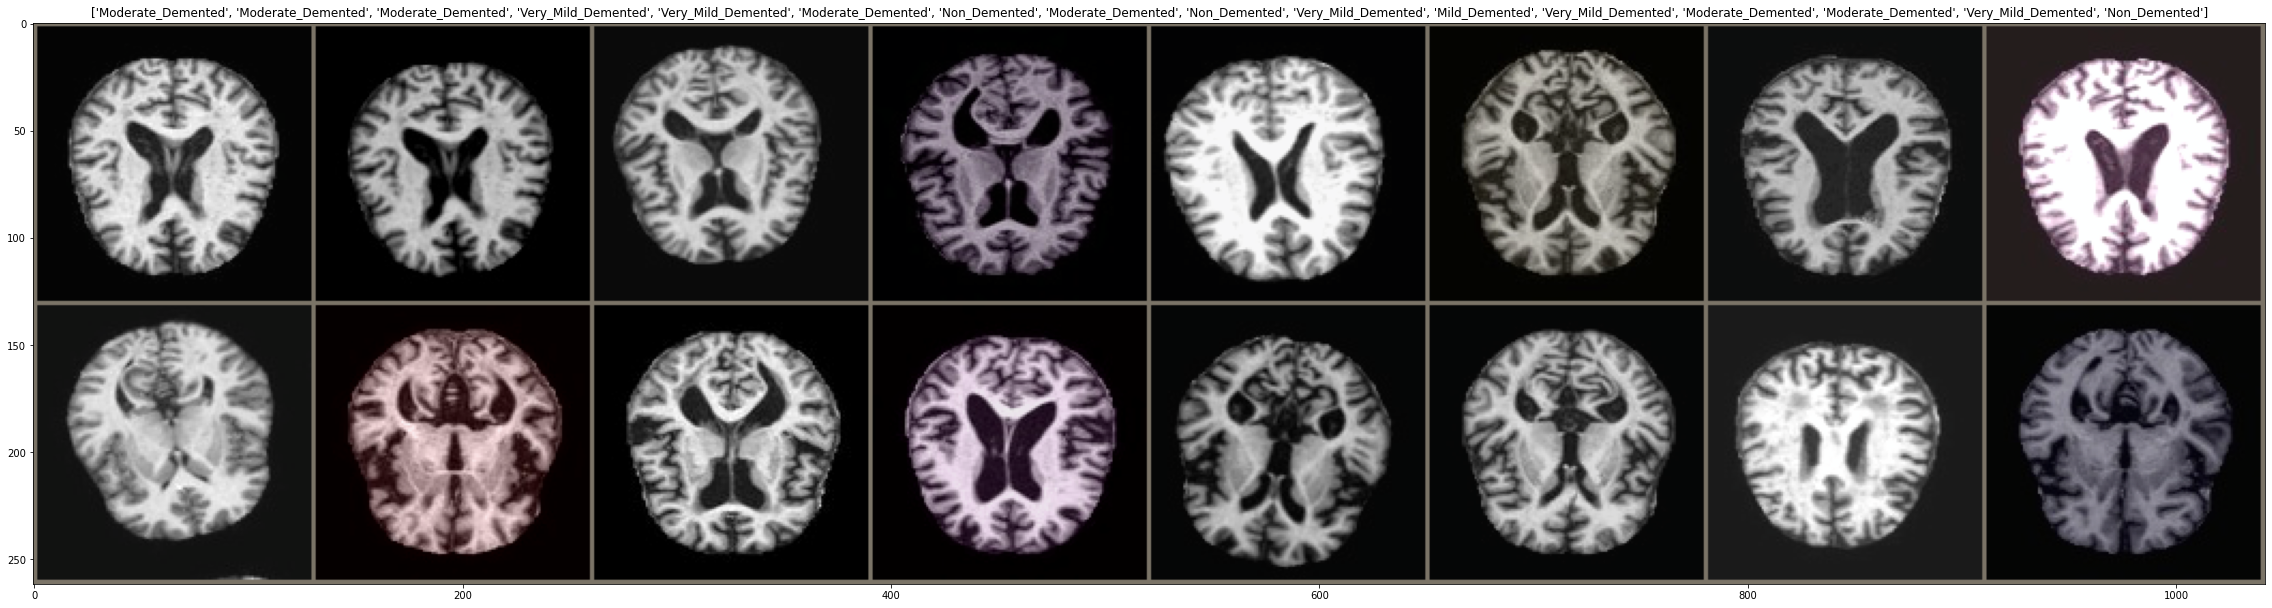

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(40,40))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [28]:
def train_model(model, criterion, optimizer, scheduler, name, num_epochs=25):

    #Creating a folder to save the model performance.
    try:
        os.mkdir(f'./modelPerformance/{name}')
    except:
        print('Dosya var')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #epochs
            
            epoch=int(len(image_datasets[phase])/BATCH_SIZE)
            
            for _ in tqdm(range(epoch)):
                #Loading Data
                
                inputs, labels = next(iter(dataloaders[phase]))
                
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            
            #epoch_auc= running_auc/(dataset_sizes[phase]-error)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f} , epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(        
                phase, epoch_loss, epoch_acc))
    
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model,'./modelPerformance/{}/best_model_{:.4f}acc_{}epochs.h5'.format(name,epoch_acc,num_epochs))

                train_losses = []
                valid_losses = []
            
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    with open(f'./modelPerformance/{name}/'+sorted(os.listdir(f'./modelPerformance/{name}/'))[-1], 'rb') as f:
        buffer = io.BytesIO(f.read())
    model=torch.load(buffer)
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

### There are plenty of models that we can use for this operation. I chose resnet50 for it. Also, you can use weights in order to get better results but I cant apply that in kaggle because of allennlp conflict. If you can fix that let me know...

In [29]:
# A dictionary of models.
modeller={
    'resnet50':models.resnet50(pretrained=True),
    
}

try:
    os.mkdir('./modelPerformance')
except:
    print('File Exists')
"""
'resnet50':models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
    'resnext':models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights)
'resnet50':models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
    'resnext':models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights)

'Vit_b_16': models.vit_b_16(pretrained=True),
    'Vit_b_32': models.vit_b_32(pretrained=True),
    'Vit_h_14': models.vit_h_14(),
    'Vit_l_16': models.vit_l_16(pretrained=True),
    'Vit_l_32': models.vit_l_32(pretrained=True),
'resnet18':models.resnet18(pretrained=True),
    'resnet34':models.resnet34(pretrained=True),
    
    'densenet121':models.densenet121(pretrained=True),
    'densenet169':models.densenet169(pretrained=True),
    
"""

File Exists


"\n'resnet50':models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),\n    'resnext':models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights)\n'resnet50':models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),\n    'resnext':models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights)\n\n'Vit_b_16': models.vit_b_16(pretrained=True),\n    'Vit_b_32': models.vit_b_32(pretrained=True),\n    'Vit_h_14': models.vit_h_14(),\n    'Vit_l_16': models.vit_l_16(pretrained=True),\n    'Vit_l_32': models.vit_l_32(pretrained=True),\n'resnet18':models.resnet18(pretrained=True),\n    'resnet34':models.resnet34(pretrained=True),\n    \n    'densenet121':models.densenet121(pretrained=True),\n    'densenet169':models.densenet169(pretrained=True),\n    \n"

### EPOCH=35 should be more convinient for this case. We have lots of data to train...

In [30]:
for name,model in modeller.items(): 
    model_ft = model
    
    # In vgg there are different kind of settings to train
    if 'vgg' in name:
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Sequential(nn.Linear(num_ftrs, len(class_names)),nn.Softmax())
    else:
        num_ftrs = model_ft.fc.in_features
        model_ft.fc =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())


    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


    # TRAINING
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, name=name,
                            num_epochs=EPOCH)

Dosya var
Epoch 1/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.61it/s]


train Loss: 1.1229 Acc: 0.6047


100%|██████████| 119/119 [00:04<00:00, 28.76it/s]


val Loss: 1.1265 Acc: 0.5941

Epoch 2/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.63it/s]


train Loss: 1.0303 Acc: 0.7058


100%|██████████| 119/119 [00:04<00:00, 28.89it/s]


val Loss: 1.1109 Acc: 0.6170

Epoch 3/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.61it/s]


train Loss: 0.9739 Acc: 0.7659


100%|██████████| 119/119 [00:04<00:00, 29.14it/s]


val Loss: 1.1352 Acc: 0.5899

Epoch 4/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.67it/s]


train Loss: 0.9333 Acc: 0.8064


100%|██████████| 119/119 [00:04<00:00, 27.95it/s]


val Loss: 1.1276 Acc: 0.5982

Epoch 5/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.68it/s]


train Loss: 0.8931 Acc: 0.8470


100%|██████████| 119/119 [00:04<00:00, 29.04it/s]


val Loss: 1.0154 Acc: 0.7045

Epoch 6/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.63it/s]


train Loss: 0.8800 Acc: 0.8611


100%|██████████| 119/119 [00:04<00:00, 28.79it/s]


val Loss: 0.9961 Acc: 0.7285

Epoch 7/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.64it/s]


train Loss: 0.8594 Acc: 0.8815


100%|██████████| 119/119 [00:03<00:00, 29.87it/s]


val Loss: 0.9186 Acc: 0.8082

Epoch 8/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.67it/s]


train Loss: 0.8129 Acc: 0.9302


100%|██████████| 119/119 [00:04<00:00, 29.64it/s]


val Loss: 0.8711 Acc: 0.8567

Epoch 9/45
----------


100%|██████████| 1123/1123 [01:57<00:00,  9.56it/s]


train Loss: 0.8020 Acc: 0.9407


100%|██████████| 119/119 [00:03<00:00, 29.79it/s]


val Loss: 0.8565 Acc: 0.8697

Epoch 10/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.62it/s]


train Loss: 0.7937 Acc: 0.9499


100%|██████████| 119/119 [00:04<00:00, 29.70it/s]


val Loss: 0.8572 Acc: 0.8723

Epoch 11/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.66it/s]


train Loss: 0.7884 Acc: 0.9554


100%|██████████| 119/119 [00:04<00:00, 27.96it/s]


val Loss: 0.8423 Acc: 0.8854

Epoch 12/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.65it/s]


train Loss: 0.7849 Acc: 0.9583


100%|██████████| 119/119 [00:03<00:00, 29.79it/s]


val Loss: 0.8437 Acc: 0.8838

Epoch 13/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.64it/s]


train Loss: 0.7825 Acc: 0.9615


100%|██████████| 119/119 [00:03<00:00, 29.96it/s]


val Loss: 0.8332 Acc: 0.8973

Epoch 14/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.61it/s]


train Loss: 0.7779 Acc: 0.9661


100%|██████████| 119/119 [00:04<00:00, 28.77it/s]


val Loss: 0.8344 Acc: 0.8958

Epoch 15/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.63it/s]


train Loss: 0.7760 Acc: 0.9676


100%|██████████| 119/119 [00:04<00:00, 29.49it/s]


val Loss: 0.8332 Acc: 0.8979

Epoch 16/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.61it/s]


train Loss: 0.7760 Acc: 0.9677


100%|██████████| 119/119 [00:04<00:00, 28.86it/s]


val Loss: 0.8274 Acc: 0.9041

Epoch 17/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.63it/s]


train Loss: 0.7735 Acc: 0.9705


100%|██████████| 119/119 [00:04<00:00, 29.14it/s]


val Loss: 0.8265 Acc: 0.9041

Epoch 18/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.66it/s]


train Loss: 0.7740 Acc: 0.9702


100%|██████████| 119/119 [00:04<00:00, 28.31it/s]


val Loss: 0.8347 Acc: 0.8927

Epoch 19/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.65it/s]


train Loss: 0.7724 Acc: 0.9710


100%|██████████| 119/119 [00:04<00:00, 28.87it/s]


val Loss: 0.8274 Acc: 0.9010

Epoch 20/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.66it/s]


train Loss: 0.7733 Acc: 0.9708


100%|██████████| 119/119 [00:04<00:00, 29.10it/s]


val Loss: 0.8217 Acc: 0.9078

Epoch 21/45
----------


100%|██████████| 1123/1123 [01:57<00:00,  9.56it/s]


train Loss: 0.7705 Acc: 0.9733


100%|██████████| 119/119 [00:04<00:00, 28.96it/s]


val Loss: 0.8291 Acc: 0.8999

Epoch 22/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.63it/s]


train Loss: 0.7718 Acc: 0.9721


100%|██████████| 119/119 [00:04<00:00, 28.45it/s]


val Loss: 0.8353 Acc: 0.8953

Epoch 23/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.67it/s]


train Loss: 0.7737 Acc: 0.9701


100%|██████████| 119/119 [00:04<00:00, 27.73it/s]


val Loss: 0.8207 Acc: 0.9078

Epoch 24/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.65it/s]


train Loss: 0.7741 Acc: 0.9699


100%|██████████| 119/119 [00:04<00:00, 28.98it/s]


val Loss: 0.8317 Acc: 0.8979

Epoch 25/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.63it/s]


train Loss: 0.7703 Acc: 0.9737


100%|██████████| 119/119 [00:04<00:00, 29.18it/s]


val Loss: 0.8218 Acc: 0.9093

Epoch 26/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.63it/s]


train Loss: 0.7714 Acc: 0.9722


100%|██████████| 119/119 [00:04<00:00, 29.00it/s]


val Loss: 0.8373 Acc: 0.8932

Epoch 27/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.64it/s]


train Loss: 0.7716 Acc: 0.9722


100%|██████████| 119/119 [00:04<00:00, 29.36it/s]


val Loss: 0.8253 Acc: 0.9062

Epoch 28/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.64it/s]


train Loss: 0.7725 Acc: 0.9714


100%|██████████| 119/119 [00:04<00:00, 28.10it/s]


val Loss: 0.8302 Acc: 0.8984

Epoch 29/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.60it/s]


train Loss: 0.7709 Acc: 0.9728


100%|██████████| 119/119 [00:04<00:00, 27.14it/s]


val Loss: 0.8239 Acc: 0.9057

Epoch 30/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.65it/s]


train Loss: 0.7718 Acc: 0.9722


100%|██████████| 119/119 [00:04<00:00, 28.87it/s]


val Loss: 0.8192 Acc: 0.9119

Epoch 31/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.62it/s]


train Loss: 0.7705 Acc: 0.9734


100%|██████████| 119/119 [00:04<00:00, 29.24it/s]


val Loss: 0.8267 Acc: 0.9057

Epoch 32/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.64it/s]


train Loss: 0.7707 Acc: 0.9735


100%|██████████| 119/119 [00:04<00:00, 29.38it/s]


val Loss: 0.8385 Acc: 0.8911

Epoch 33/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.65it/s]


train Loss: 0.7701 Acc: 0.9739


100%|██████████| 119/119 [00:04<00:00, 28.84it/s]


val Loss: 0.8365 Acc: 0.8942

Epoch 34/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.61it/s]


train Loss: 0.7708 Acc: 0.9730


100%|██████████| 119/119 [00:04<00:00, 28.62it/s]


val Loss: 0.8344 Acc: 0.8937

Epoch 35/45
----------


100%|██████████| 1123/1123 [01:54<00:00,  9.82it/s]


train Loss: 0.7724 Acc: 0.9718


100%|██████████| 119/119 [00:04<00:00, 29.05it/s]


val Loss: 0.8184 Acc: 0.9125

Epoch 36/45
----------


100%|██████████| 1123/1123 [01:54<00:00,  9.78it/s]


train Loss: 0.7708 Acc: 0.9730


100%|██████████| 119/119 [00:04<00:00, 29.51it/s]


val Loss: 0.8172 Acc: 0.9135

Epoch 37/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.65it/s]


train Loss: 0.7701 Acc: 0.9736


100%|██████████| 119/119 [00:04<00:00, 29.17it/s]


val Loss: 0.8368 Acc: 0.8916

Epoch 38/45
----------


100%|██████████| 1123/1123 [01:54<00:00,  9.84it/s]


train Loss: 0.7694 Acc: 0.9745


100%|██████████| 119/119 [00:03<00:00, 30.41it/s]


val Loss: 0.8249 Acc: 0.9067

Epoch 39/45
----------


100%|██████████| 1123/1123 [01:56<00:00,  9.67it/s]


train Loss: 0.7713 Acc: 0.9732


100%|██████████| 119/119 [00:03<00:00, 30.38it/s]


val Loss: 0.8198 Acc: 0.9067

Epoch 40/45
----------


100%|██████████| 1123/1123 [01:54<00:00,  9.84it/s]


train Loss: 0.7726 Acc: 0.9713


100%|██████████| 119/119 [00:03<00:00, 30.38it/s]


val Loss: 0.8260 Acc: 0.9046

Epoch 41/45
----------


100%|██████████| 1123/1123 [01:53<00:00,  9.87it/s]


train Loss: 0.7695 Acc: 0.9746


100%|██████████| 119/119 [00:04<00:00, 29.73it/s]


val Loss: 0.8390 Acc: 0.8906

Epoch 42/45
----------


100%|██████████| 1123/1123 [01:53<00:00,  9.86it/s]


train Loss: 0.7713 Acc: 0.9726


100%|██████████| 119/119 [00:03<00:00, 30.43it/s]


val Loss: 0.8224 Acc: 0.9072

Epoch 43/45
----------


100%|██████████| 1123/1123 [01:54<00:00,  9.85it/s]


train Loss: 0.7726 Acc: 0.9716


100%|██████████| 119/119 [00:03<00:00, 30.38it/s]


val Loss: 0.8442 Acc: 0.8854

Epoch 44/45
----------


100%|██████████| 1123/1123 [01:53<00:00,  9.86it/s]


train Loss: 0.7726 Acc: 0.9713


100%|██████████| 119/119 [00:03<00:00, 30.10it/s]


val Loss: 0.8324 Acc: 0.8973

Epoch 45/45
----------


100%|██████████| 1123/1123 [01:54<00:00,  9.82it/s]


train Loss: 0.7716 Acc: 0.9722


100%|██████████| 119/119 [00:03<00:00, 30.37it/s]


val Loss: 0.8404 Acc: 0.8916

Training complete in 90m 34s
Best val Acc: 0.913497


In [36]:
def test_model(model ,device, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
    print('Test Accuracy = {:f}'.format(correct / total))

'best_model_0.9135acc_45epochs.h5'

In [ ]:
sorted(os.listdir('./modelPerformance/vgg16'))[-1]

In [ ]:
modeller={vgg16:sorted(os.listdir('./modelPerformance/vgg16'))[-1]}
for name,model in modeller.items():
    print('\n'+name+'\n-----------------')  
    model_ft=torch.load(model)
    actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders['val'])
    get_metric.test_model(model_ft,device,dataloaders['val'])
    get_metric.get_cohen_kappa(actuals, predictions)
    get_metric.get_roc_curves(model_ft, device,  dataloaders['val'])
    get_metric.get_confusion_matrix(actuals, predictions)